In [153]:
%matplotlib inline

# Recipe graph

## Get a list of recipes

```
wget https://www.auntiesrecipes.co.uk/code/titles.json
```

Courtesy of this repository:

https://github.com/user24/auntiesrecipes

In [2]:
import json

In [3]:
titles = json.load(open('titles.json'))

## Downloading the recipe web pages

First we'll download a set of web pages containing different recipes. For now, we'll just store these web pages and parse them later to extract ingredients

In [137]:
import requests
import sys

def clean_ingredient(ingredient):
    '''
    Chop off any modifiers, such as "to taste", "halved", etc...
    
    :param ingredient: The name of the ingredient (e.g., "nutmeg", "pepper, chopped")
    '''
    return ingredient.strip().split(',')[0]

responses = {}

# go through all the recipes
print("total recipes:", len(titles.keys()))

for i,recipe_name in enumerate(titles.keys()[:20]):
    # get the web page
    responses[recipe_name] = requests.get("http://www.bbc.co.uk/food/recipes/" + recipe_name)
    sys.stdout.write("{} ".format(i))


                

('total recipes:', 11161)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

## Parsing for ingredients

Each web page contains a list of ingredients, but they're formatted as HTML and unpleasant to read:

```
    <ul class="recipe-ingredients__list">
    
        <li class="recipe-ingredients__list-item" itemprop="ingredients"> 6 skinless <a href="/food/chicken_leg" class="recipe-ingredients__link">chicken legs</a> (thigh and drumstick)	</li>
    
        <li class="recipe-ingredients__list-item" itemprop="ingredients"> 4 <a href="/food/celery" class="recipe-ingredients__link">celery</a> sticks, diced</li>
    
        <li class="recipe-ingredients__list-item" itemprop="ingredients"> 4 <a href="/food/bay_leaf" class="recipe-ingredients__link">bay leaves</a>, roughly sliced</li>
   </ul>
```

We want to extract they ingredient names and store them in a more friendly data structure.

In [158]:
import lxml.etree as etree
import lxml.cssselect as ls
import cssselect as css

import collections as col

def create_ingredients_map(responses, clean_ingredient=lambda x: x):
    ingredients_map = col.defaultdict(lambda: {'coingredients': set(), 'recipes': set()})

    for recipe_name,response in responses:    
        # select ingredient lists
        expression = css.GenericTranslator().css_to_xpath('ul')
        sel = ls.CSSSelector('.recipe-ingredients__list')

        tree = etree.HTML(response.content)
        ingredient_lists = sel(tree)

        # go through each ingredient in the ingredient list
        sel_ingredient = ls.CSSSelector('.recipe-ingredients__link')
        for ingredients_list in ingredient_lists:
            for ingredient in sel_ingredient(ingredients_list):
                ingredient_name = clean_ingredient(etree.tostring(ingredient, encoding='iso-8859-1', method='text')).decode('utf-8')
                ingredients_map[ingredient_name]['recipes'].add(recipe_name)

                for coingredient in sel_ingredient(ingredients_list):
                    coingredient = clean_ingredient(etree.tostring(coingredient, encoding='iso-8859-1', method='text')).decode('utf-8')

                    if coingredient == ingredient_name:
                        continue


                    ingredients_map[ingredient_name]['coingredients'].add(coingredient)
                    
    return ingredients_map

In [216]:
used_responses = responses.items()[:20]

In [217]:
ingredients_map = create_ingredients_map(used_responses)
print("\n".join(ingredients_map.keys()[:8]))

celery sticks, diced
vegetable oil
rocket leaves
ale
plain flour, plus extra for dusting
puff pastry
sesame oil
parmesan


## Cleaning the data

Notice how some of the ingredients contain extra information:

```
plain flour, plus extra for dusting 
chicken legs (thigh and drumstick)	
```

We're not interested in these modifiers and want to remove them.

In [218]:
def remove_parens(test_str):
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret


In [219]:
def clean_ingredient(ingredient):
    '''
    Chop off any modifiers, such as "to taste", "halved", etc...
    
    :param ingredient: The name of the ingredient (e.g., "nutmeg", "pepper, chopped")
    '''
    no_comma = ingredient.strip().split(',')[0]
    result = remove_parens(no_comma)
    
    return result

ingredients_map = create_ingredients_map(used_responses, clean_ingredient)
print("\n".join(ingredients_map.keys()[:8]))

vegetable oil
icing sugar
self-raising flour
ale
Worcestershire sauce
courgettes
puff pastry
Stilton cheese


In [220]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(ingredients_map.keys())

for ingredient_name,ingredient_data in ingredients_map.items():
    for coingredient in ingredient_data['coingredients']:
        G.add_edge(ingredient_name, coingredient)

hi


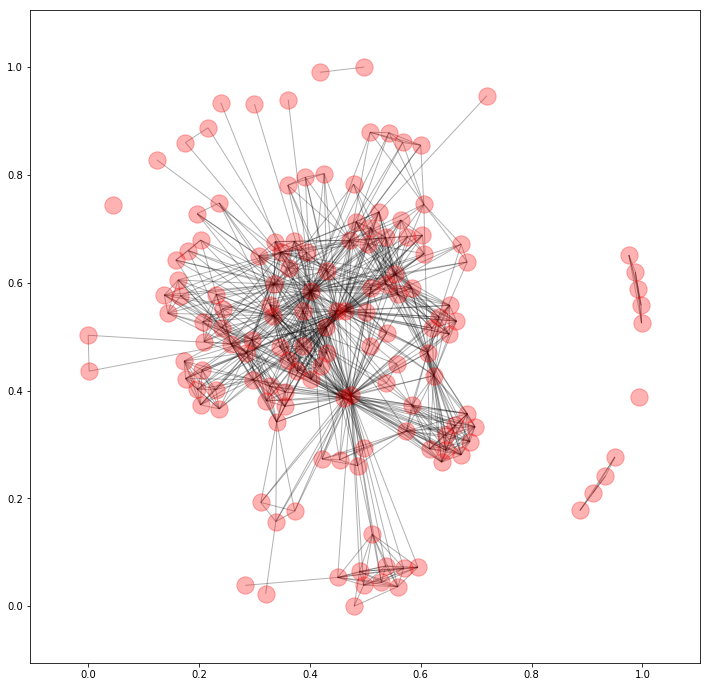

In [221]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(12,12))
pos=nx.spring_layout(G) # positions for all nodes
#nx.draw(G)
nx.draw_networkx_nodes(G, pos, alpha=0.3)
nx.draw_networkx_edges(G, pos, alpha=0.3)
#nx.draw_networkx_labels(G, pos)
print("hi")